# Final Project - **Mobility Management**
>

In [ ]:
import random
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import seaborn as sns

## Parameters


In [ ]:
#Location of Base Station and its corresponding Allocation
#Allocation - #overall performance measured of the Base Station

BS_allocations = [5, 5, 5, 5, 9, 5, 5, 5, 5, 7, 7, 7, 7]
BS_coords = [(0,0),(0,22),(0,44),(22,0),(22,22),(22,44),(44,0),(44,22),(44,44),(11,11),(11,33),(33,11),(33,33)]

low_service_areas = [(22, 23), (22, 24), (22, 25), (22, 26), (22, 27), (22, 28), (22, 29), (22,30), (22, 31),(22, 32),(22,33),
                    (23, 23), (23, 24), (23, 25), (23, 26), (23, 27), (23, 28), (23, 29), (23,30), (23, 31), (23, 32),
                    (24, 23), (24, 24), (24, 25), (24, 26), (24, 27), (24, 28), (24, 29), (24,30), (24, 31),
                    (25, 23), (25, 24), (25, 25), (25, 26), (25, 27), (25, 28), (25, 29), (25,30),/WMN_final_project.ipynb
                    (26, 23), (26, 24), (26, 25), (26, 26), (26, 27), (26, 28), (26, 29),
                    (27, 23), (27, 24), (27, 25), (27, 26), (27, 27), (27, 28),
                    (28, 23), (28, 24), (28, 25), (28, 26), (28, 27),
                    (29, 23), (29, 24), (29, 25), (29, 26),
                    (30, 23), (30, 24), (30, 25),
                    (31, 23), (31, 24),
                    (32, 23)]

low_service_area_allocation = 1

show = np.zeros((44,44))

# =============== parameters for SINR ===================
g_bs = 14                 # antenna gain of base stations (in dB)
g_m = 14                  # antenna gain of mobile devices (in dB)
h_bs = 50                 # height of base stations (in meters)
h_ms = 1.5                # height of mobile devices (in meters)

speed = 10
BW = 10e6
ptx = 33 #dbm in this case is BS
preceiver =23 #dbm in this case is MS

g_bs_W = np.power(10,g_bs/10)
g_m_W = np.power(10, g_m/10)

# ---------------parameters that input by the user------------------
#speed, BW, ptx, preceiver = map(int, map(str.strip, input("Enter speed, BW, BS power(dBm), MS power(dBm) separated by comma: ").split(',')))
#print(BW)
#print(ptx)
#print(preceiver)
ptx_W = np.power(10,((ptx-30)/10))
preceiver_W = np.power(10,((preceiver-30)/10))


k = 1.38e-23
T = 27 + 273.15
noise = k*T*BW

## Functions for **calculation**

In [ ]:
def get_distance(coords):
  total_distance = []
  for bs in BS_coords:
    delta_x = bs[0]-coords[0]        # BS posiㄋion(x) - MS position(x)
    delta_y = bs[1]-coords[1]        # BS position(y) - MS position(y)
    distance = math.sqrt(delta_x**2 + delta_y**2)
    total_distance.append(distance)
  return total_distance               # would be a list contains 13 distances

# =================== based on the distance ===================
def get_bs(coords, debug=False):
    if debug: print("Mobile Position: " + str(coords))
    closest_bs = []
    distances = []
    distances = get_distance(coords)
    # print(distances)

    closest_bs = np.argsort(distances)[:3]     # return the index of the closest basestations
    closest_bs = [x+1 for x in closest_bs]

    if debug: print("Closest Base Stations are :", closest_bs)
    return closest_bs


# =================== based on the SINR ===================
def get_pathloss(distance):
  gd = []

  for x in distance:
    pathloss = (h_bs*h_ms)**2 / x**4
    gd.append(pathloss)

  return gd

def get_receivepower(gd):
  # Downlink(PT is BS power, GT is BS gain, GR is MS gain)
  PR = []

  for x in gd:
    pr = x*ptx_W*g_bs_W*g_m_W
    PR.append(pr)

  return PR

def get_interference(PR):
  '''
  UL(MS received power), Downlink(BS received power)
  In this case, we only do downlink
  PR_all - list of all received power
  PR - the PR of the focused BS
  '''

  interference = []
  pr_all = sum(PR)

  for pr in PR:
    temp = pr_all - pr
    interference.append(temp)

  return interference

def get_SINR(PR,interference):
  SINR = []

  for i in range(len(PR)):
    temp = PR[i]/(interference[i]+noise)
    SINR.append(temp)

  return SINR

def get_bs_sinr(coords, debug=False):
  if debug: print("Mobile Position: " + str(coords))

  chosen_bs = []
  distance = get_distance(coords)
  pathloss = get_pathloss(distance)
  receive_power = get_receivepower(pathloss)
  interference = get_interference(receive_power)
  SINR = get_SINR(receive_power, interference)

  chosen_bs = np.argsort(SINR)[::-1][:3]   # return the index of the closest 3 base stations
  chosen_bs = [x+1 for x in chosen_bs]

  if debug: print("Closest base stations are :", chosen_bs, "SINR be like: ", SINR)
  return chosen_bs

## Functions for **experiment**

In [ ]:
def mobile_move(location, n):
    current_x = location[0]
    current_y = location[1]
    for i in range(n):
      valid_step = False
      while not valid_step:
        step = random.choice(['N', 'W', 'E', 'S'])
        new_x = current_x
        new_y = current_y
        if step == 'N' and current_y < 44:
          new_y = current_y + 1
        elif step == 'S' and current_y > 0:
          new_y = current_y - 1
        elif step == 'E' and current_x < 44:
          new_x = current_x + 1
        elif step == 'W' and current_x > 0:
          new_x = current_x - 1
        if (new_x, new_y) not in BS_coords:
          valid_step = True
          current_x = new_x
          current_y = new_y
    return (current_x, current_y)


def get_allocation(low_service_area, BS, coords):
    allocation = BS_allocations[BS-1]
    if low_service_area:
        if coords in low_service_areas: # If Mobile is in low service zone, allocation is 1
            allocation = low_service_area_allocation
    return allocation


def main_function(soft_handoff=False, low_service_area = False, num_trials=10, num_walks=1000, num_steps=5, exp_type = "distance", debug=False):

    """
    Simulates the main function behavior.

    Args:
        soft_handoff_enabled (bool): Flag indicating if soft handoff is enabled.
        low_service_area_enabled (bool): Flag indicating if low service area is enabled.
        num_trials (int): Number of trials to run.
        num_walks (int): Number of walks in each trial.
        num_steps (int): Number of steps to take in each walk.
        exp_type (str): Type of experiment, either "distance" or "sinr".
        debug (bool): Flag indicating if debug messages should be printed.

    Returns:
        tuple: A tuple containing the average allocations, heatmap, and lastallocation arrays.
    """

    # the type could only be "distance" or "sinr", else the function would return
    if exp_type != "distance" and exp_type != "sinr": return
    heatmap = np.zeros([45, 45])
    values = np.zeros((45,45), dtype=object)

    avg_allocations = []
    neglected_counter = 0
    handoff_counter = 0
    handoff_events = 0
    handoff_threshold = 0

    for trial_counter in range(num_trials):
        number_of_walks = num_walks
        mobile_coords = (23,23)

        if exp_type == "distance":
          bs_rank = get_bs(mobile_coords, debug)
        else:
          if debug: print("into SINR")
          bs_rank = get_bs_sinr(mobile_coords, debug)

        current_rank = bs_rank[:3]
        current_allocation = get_allocation(low_service_area, current_rank[0], mobile_coords)

        new_allocation = 0
        difference = 0
        new_rank = []
        handoff_record = {}
        allocation_dict = {}
        total_allocation = []
        lastallocation = np.zeros([45, 45])

        for walks in range(number_of_walks):
            mobile_coords = mobile_move(mobile_coords, num_steps)

            x, y = mobile_coords

            if exp_type == "distance":
              closest_bs = get_bs(mobile_coords, debug)
            else:
              closest_bs = get_bs_sinr(mobile_coords, debug)

            new_rank = closest_bs[:3]

            if debug: print("Using distance: ", get_bs(mobile_coords, debug), "using SINR: ", closest_bs)

            if current_rank[0] != new_rank[0]:
                handoff_events += 1
                handoff = current_rank + new_rank
                handoff = tuple(handoff)

                if handoff not in handoff_record:
                    if debug: print("New handoff")
                    new_allocation = get_allocation(low_service_area, new_rank[0], mobile_coords)
                    difference = new_allocation - current_allocation

                    allocation_dict[handoff] = difference

                    handoff_record[handoff] = True

                    current_rank = new_rank
                    current_allocation = new_allocation
                    handoff_counter += 1

                else:
                    if allocation_dict[handoff] >= handoff_threshold: # If expected allocation is higher, make the handoff
                        if debug: print("Better Handoff, handoffing to new base station.")
                        new_allocation = get_allocation(low_service_area, new_rank[0], mobile_coords)
                        current_allocation = new_allocation
                        handoff_counter += 1
                    else: # If expected allocation is lower:
                        if not soft_handoff: # If soft_handoff is not activated make the handoff(false)(hard handoff)
                            new_allocation = get_allocation(low_service_area, new_rank[0], mobile_coords)
                            current_allocation = new_allocation
                            handoff_counter += 1
                        else:
                            if debug: print("Worst Handoff, not handoffing to new base station.")
                            if new_rank[0] == 5 and mobile_coords in low_service_areas:
                                current_allocation = 7
                            else:
                                neglected_counter += 1
                            pass # If soft_handoff is activated(true) do not make the handoff(soft handoff)
                if debug: print("New allocation: ", new_allocation)

            else:
                current_allocation = get_allocation(low_service_area, current_rank[0], mobile_coords)

            if type(values[mobile_coords[0], mobile_coords[1]]) == list:
                values[mobile_coords[0], mobile_coords[1]].append(current_allocation)
            else:
                values[mobile_coords[0], mobile_coords[1]] = []
                values[mobile_coords[0], mobile_coords[1]].append(current_allocation)

            lastallocation[mobile_coords[0]][mobile_coords[1]] = current_allocation

            total_allocation.append(current_allocation) # After every walk add current allocation to list
        if debug: print("Trial " + str(trial_counter) + " Mean allocation: " + str(np.mean(total_allocation)))
        avg_allocations.append(np.mean(total_allocation))
    for x in range(45):
        for y in range(45):
            heatmap[x][y] = np.mean(values[x][y])

    sum_handoffs = neglected_counter + handoff_counter

    print("All Handoff Events: ", handoff_events)
    print("Neglected(soft) handoffs: ", neglected_counter)
    print("Actual handoffs: ", handoff_counter)
    print("Neglect Percentage: ", np.round(neglected_counter/handoff_events,4))
    print("Average Allocation: " + str(np.mean(avg_allocations)))
    print("Min Allocation: " + str(np.min(avg_allocations)))
    print("Max Allocation: " + str(np.max(avg_allocations)))

    return avg_allocations, heatmap, lastallocation



## Experiment with **distance base**
- Experiment1: no low_service_areaice_area
- Experiment2: with low_service_area


Normal Environment / Distance_Based / Hard Handoff Mobile: 
All Handoff Events:  1922045
Neglected(soft) handoffs:  0
Actual handoffs:  1922045
Neglect Percentage:  0.0
Average Allocation: 6.397113777777778
Min Allocation: 6.226266666666667
Max Allocation: 6.5468

Normal Environment / Distance_Based / Soft Handoff Mobile: 
All Handoff Events:  1928715
Neglected(soft) handoffs:  855000
Actual handoffs:  1073715
Neglect Percentage:  0.4433
Average Allocation: 6.776071555555556
Min Allocation: 6.619066666666667
Max Allocation: 6.9008


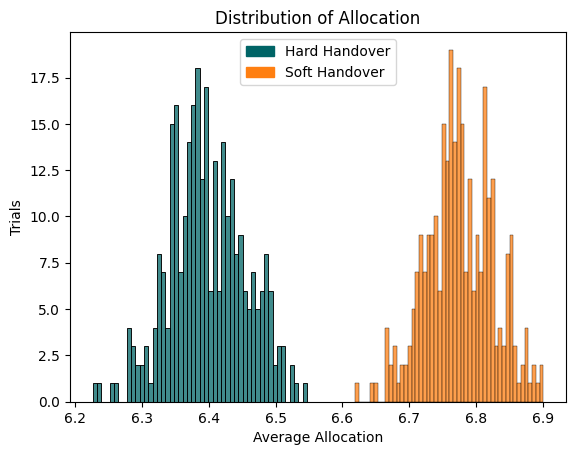

<Figure size 1400x1200 with 0 Axes>

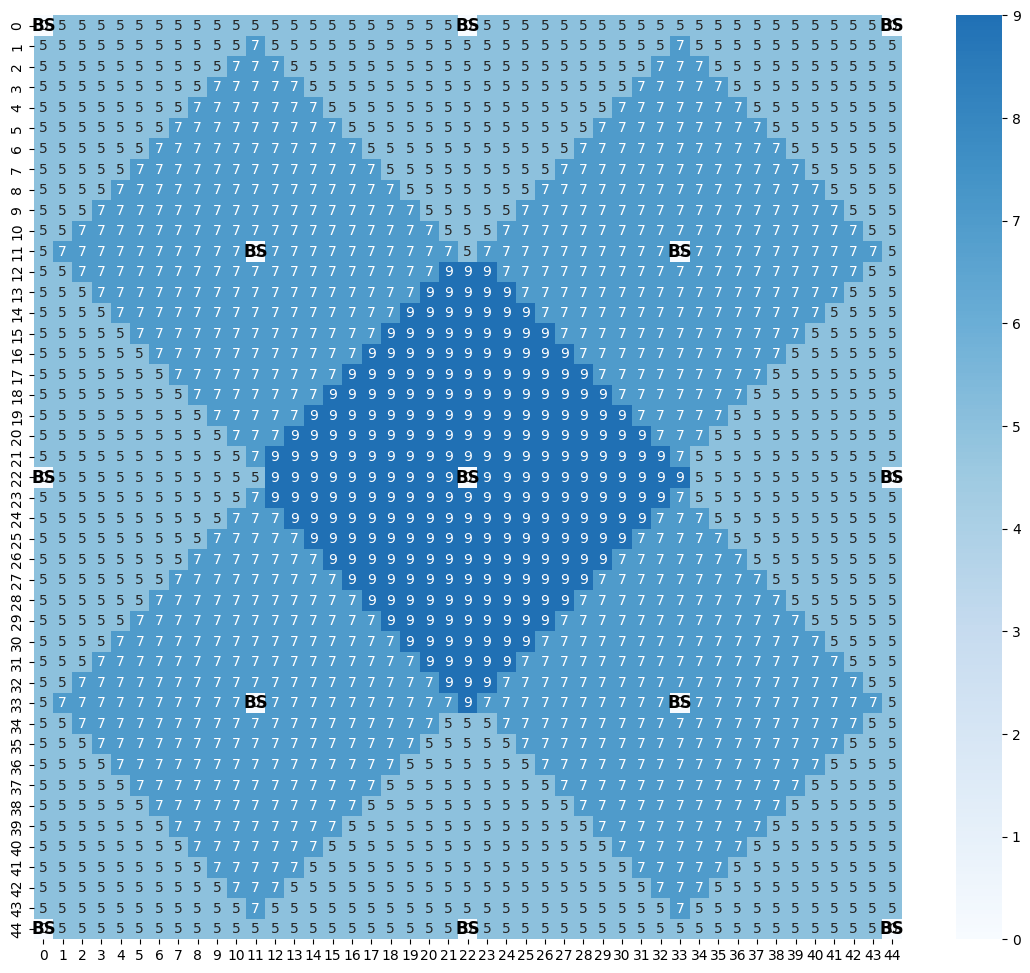

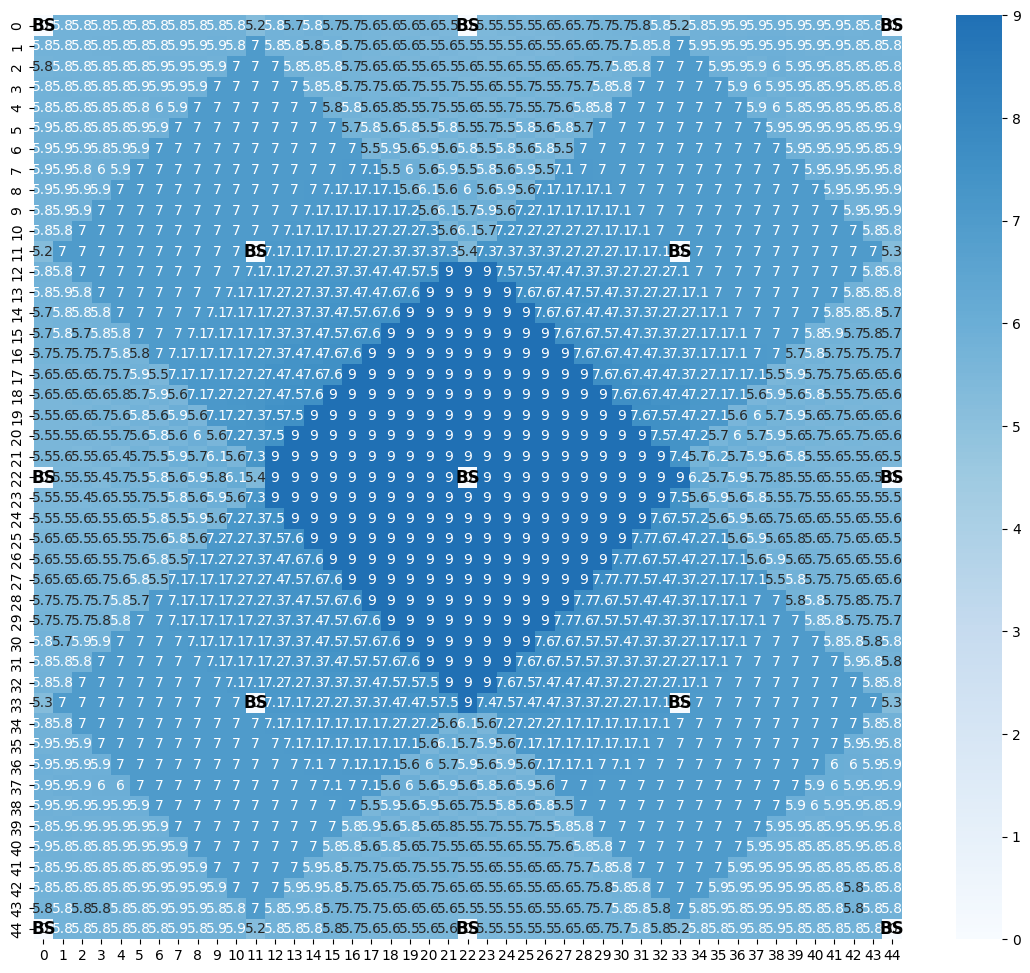

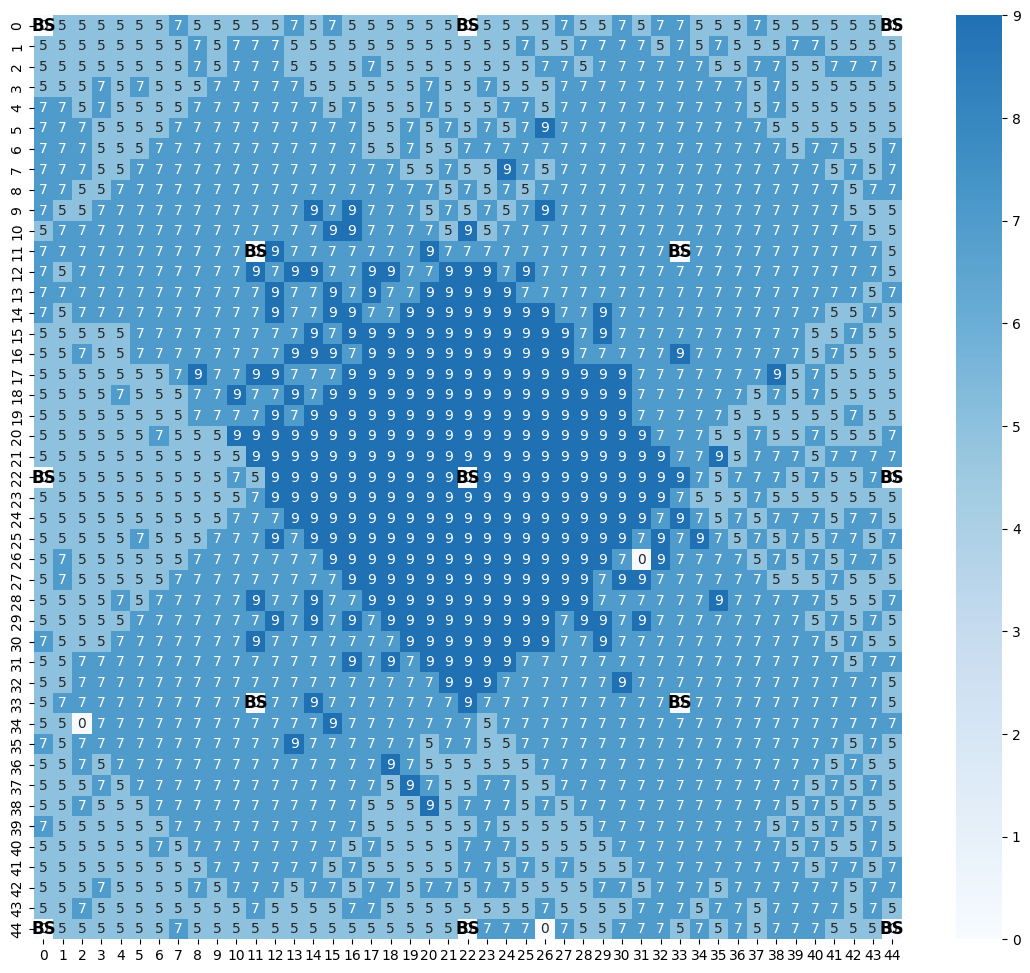


Lower Service Environment / Distance_Based / Hard Handoff Mobile: 
All Handoff Events:  1922647
Neglected(soft) handoffs:  0
Actual handoffs:  1922647
Neglect Percentage:  0.0
Average Allocation: 6.134792444444444
Min Allocation: 6.022266666666667
Max Allocation: 6.253333333333333

Lower Service Environment / Distance_Based / Soft Handoff Mobile: 
All Handoff Events:  1920722
Neglected(soft) handoffs:  816743
Actual handoffs:  1072024
Neglect Percentage:  0.4252
Average Allocation: 6.527056444444445
Min Allocation: 6.376533333333334
Max Allocation: 6.658533333333334


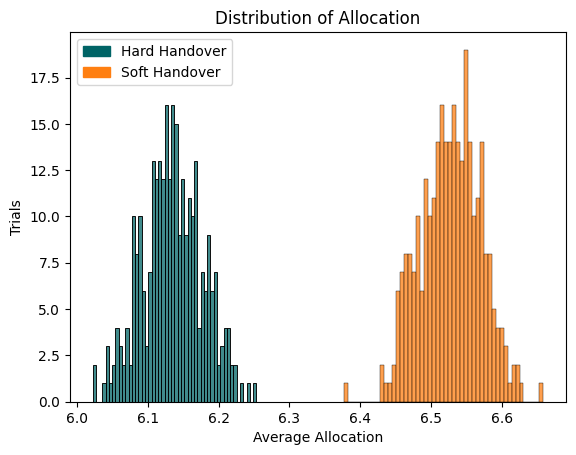

<Figure size 1400x1200 with 0 Axes>

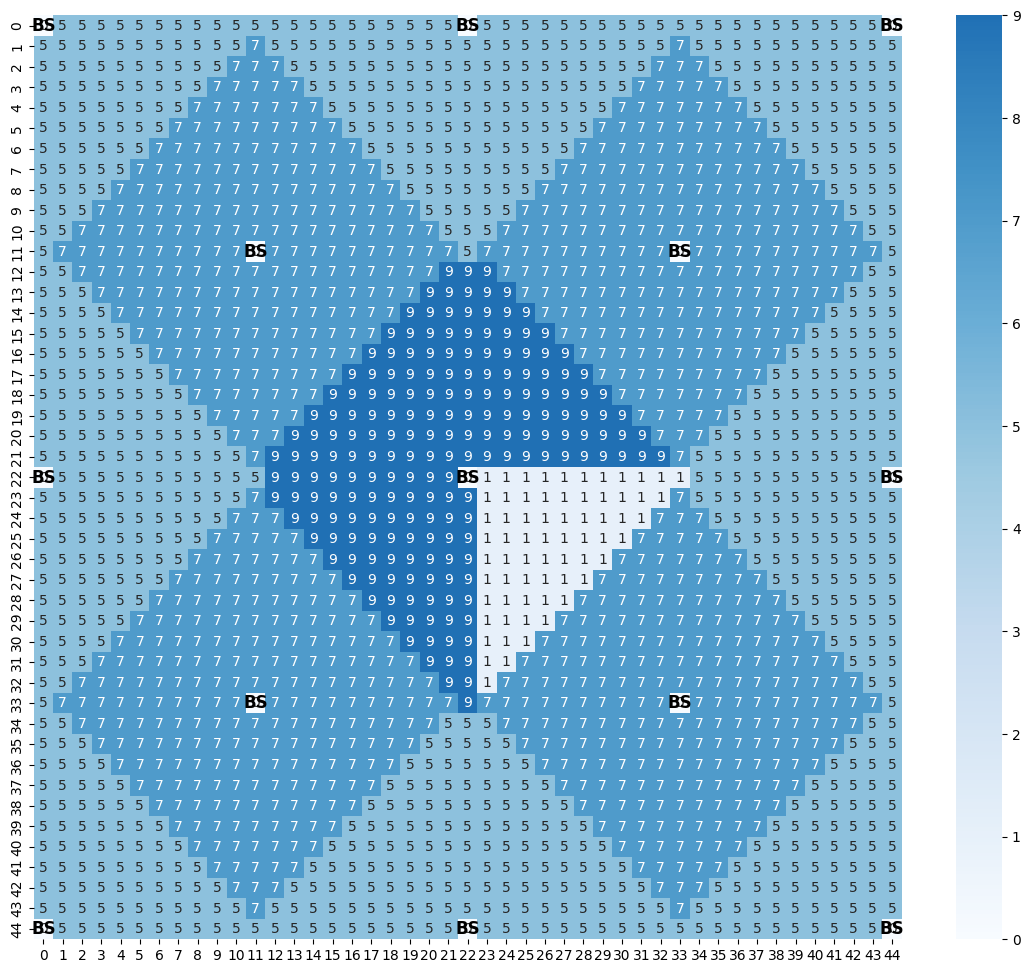

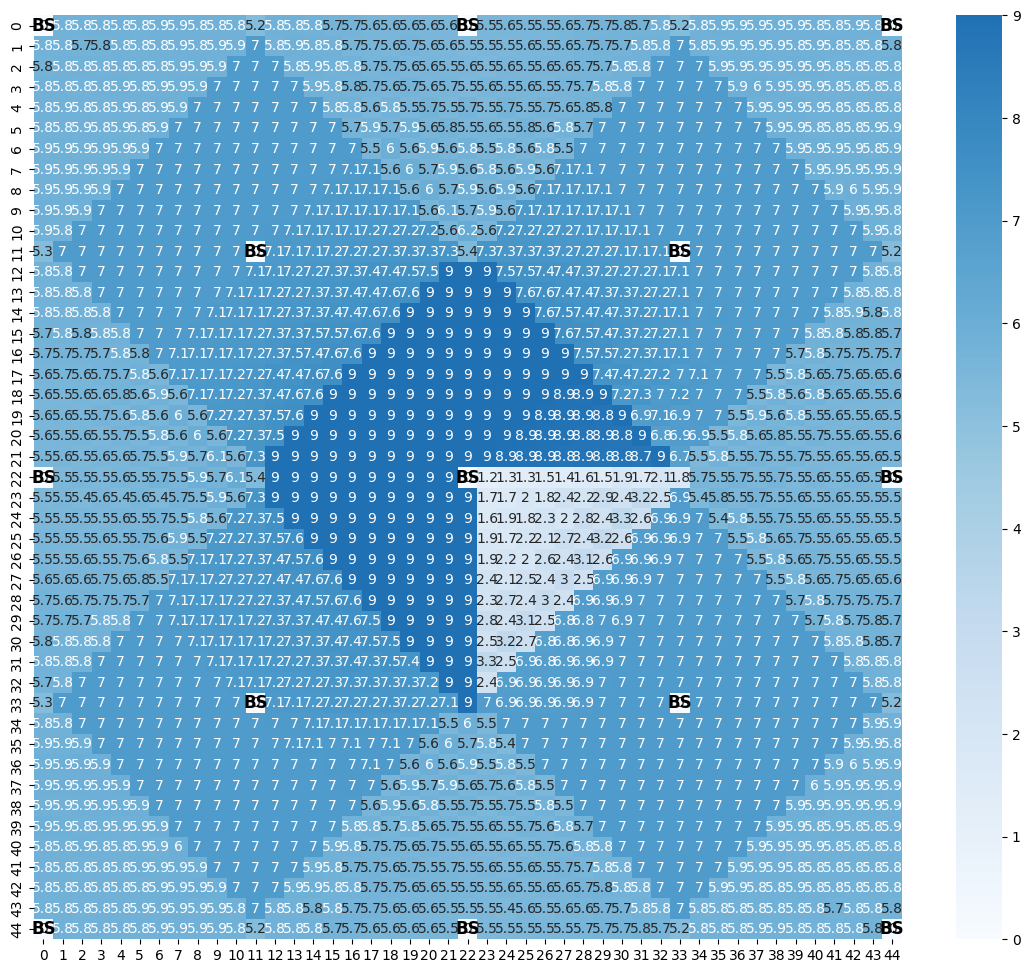

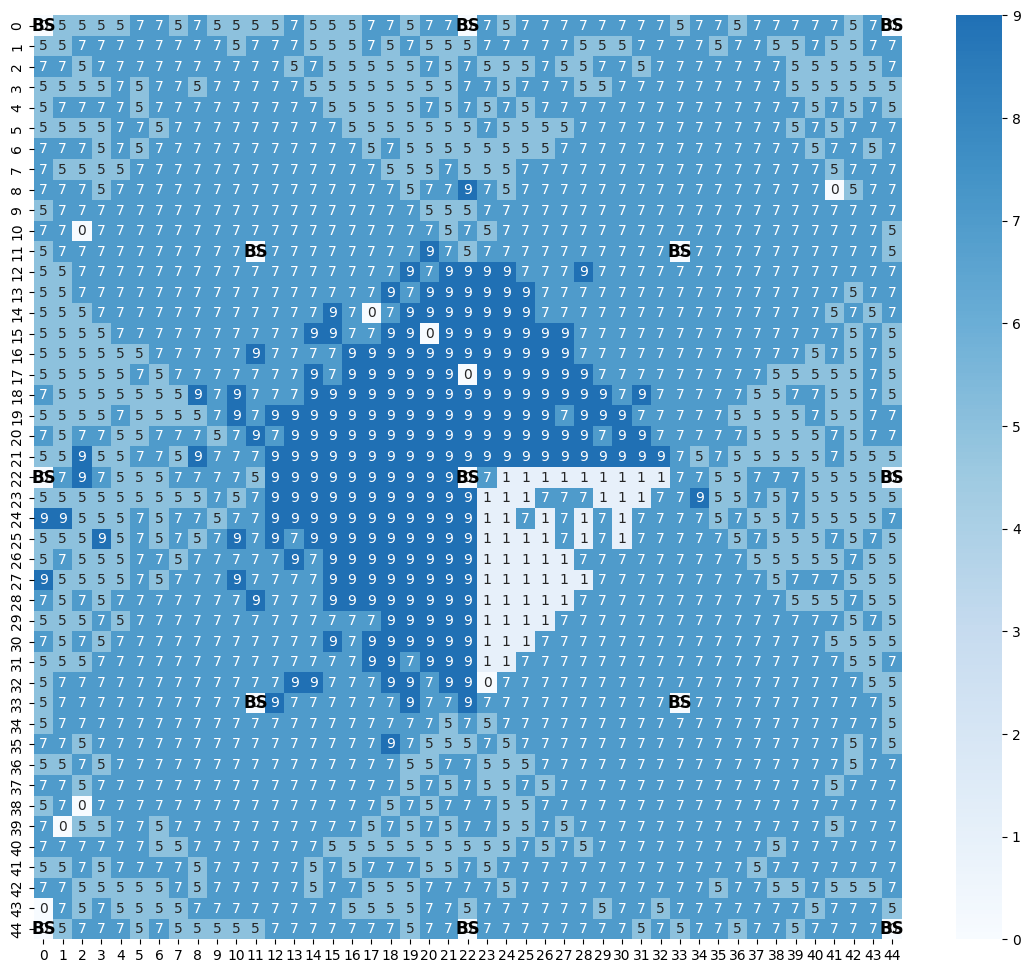

In [ ]:
# ----------------------------- Experiment 1 -----------------------------
test = 0
run1vals = []
run1means = []
run1stds = []
run1heatmaps = []
run1lastallocations = []

print("\nNormal Environment / Distance_Based / Hard Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=False,num_trials=300, num_walks=15000, num_steps=speed, exp_type="distance", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=False,num_trials=10, num_walks=10, num_steps=speed, exp_type="distance", debug=False)

run1vals.append(average_allocs)
run1means.append(np.mean(average_allocs))
run1stds.append(np.std(average_allocs))
run1heatmaps.append(heatmap)
run1lastallocations.append(lastallocation)

print("\nNormal Environment / Distance_Based / Soft Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=False,num_trials=300, num_walks=15000, num_steps=speed, exp_type="distance", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=False,num_trials=10, num_walks=10, num_steps=speed, exp_type="distance", debug=False)

run1vals.append(average_allocs)
run1means.append(np.mean(average_allocs))
run1stds.append(np.std(average_allocs))
run1heatmaps.append(heatmap)
run1lastallocations.append(lastallocation)

# Plots for Experiment 1

df = pd.DataFrame()
df["Hard Handover"] = run1vals[0]
df["Soft Handover"] = run1vals[1]

sns.histplot(run1vals[0], color = '#006466', bins=50, element="bars")
sns.histplot(run1vals[1], color = '#ff7f11', bins=50, element="bars")

teal_patch = mpatches.Patch(color='#006466', label='Hard Handover')
coral_patch = mpatches.Patch(color='#ff7f11', label='Soft Handover')

plt.legend(handles=[teal_patch, coral_patch])
plt.xlabel("Average Allocation")
plt.ylabel("Trials")
plt.title('Distribution of Allocation')
plt.figure(figsize=(14, 12))  # Set width and height
plt.savefig("distance_histogram.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run1heatmaps[0],cmap="Blues", center = 6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_hardhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run1heatmaps[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_softhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run1lastallocations[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_softhandover_single.png", dpi=300)
plt.show()
plt.close()


# ----------------------------- Experiment 2 -----------------------------


run2vals = []
run2means = []
run2stds = []
run2heatmaps = []
run2lastallocations = []

print("\nLower Service Environment / Distance_Based / Hard Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=300, num_walks=15000, num_steps=speed, exp_type="distance", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=10, num_walks=10, num_steps=speed, exp_type="distance", debug=False)

run2vals.append(average_allocs)
run2means.append(np.mean(average_allocs))
run2stds.append(np.std(average_allocs))
run2heatmaps.append(heatmap)
run2lastallocations.append(lastallocation)


print("\nLower Service Environment / Distance_Based / Soft Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=True, num_trials=300, num_walks=15000, num_steps=speed, exp_type="distance", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=10, num_walks=10, num_steps=speed, exp_type="distance", debug=False)

run2vals.append(average_allocs)
run2means.append(np.mean(average_allocs))
run2stds.append(np.std(average_allocs))
run2heatmaps.append(heatmap)
run2lastallocations.append(lastallocation)


# Plots for Experiment 2

df = pd.DataFrame()
df["Hard Handover"] = run2vals[0]
df["Soft Handover"] = run2vals[1]


sns.histplot(run2vals[0], color = '#006466', bins=50, element="bars")
sns.histplot(run2vals[1], color = '#ff7f11', bins=50, element="bars")

teal_patch = mpatches.Patch(color='#006466', label='Hard Handover')
coral_patch = mpatches.Patch(color='#ff7f11', label='Soft Handover')

plt.legend(handles=[teal_patch, coral_patch])
plt.xlabel("Average Allocation")
plt.ylabel("Trials")
plt.title('Distribution of Allocation')
plt.figure(figsize=(14, 12))  # Set width and height
plt.savefig("distance_deadzone_histogram.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run2heatmaps[0],cmap="Blues", center = 6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_deadzone_hardhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run2heatmaps[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_deadzone_softhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run2lastallocations[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("distance_deadzone_softhandover_single.png", dpi=300)
plt.show()
plt.close()



## Experiment with **sinr base**
- This part could be ignored
- Experiment3: no low_service_area
- Experiment4: with low_service_area


Normal Environment / SINR_Based / Hard Handoff Mobile: 
All Handoff Events:  1922494
Neglected(soft) handoffs:  0
Actual handoffs:  1922494
Neglect Percentage:  0.0
Average Allocation: 6.4884493333333335
Min Allocation: 6.3444
Max Allocation: 6.6436

Normal Environment / SINR_Based / Soft Handoff Mobile: 
All Handoff Events:  1926465
Neglected(soft) handoffs:  769808
Actual handoffs:  1156657
Neglect Percentage:  0.3996
Average Allocation: 6.833177777777778
Min Allocation: 6.692933333333333
Max Allocation: 7.0149333333333335


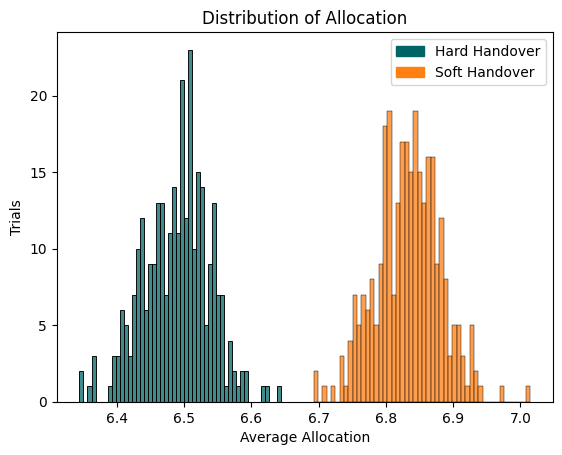

<Figure size 1400x1200 with 0 Axes>

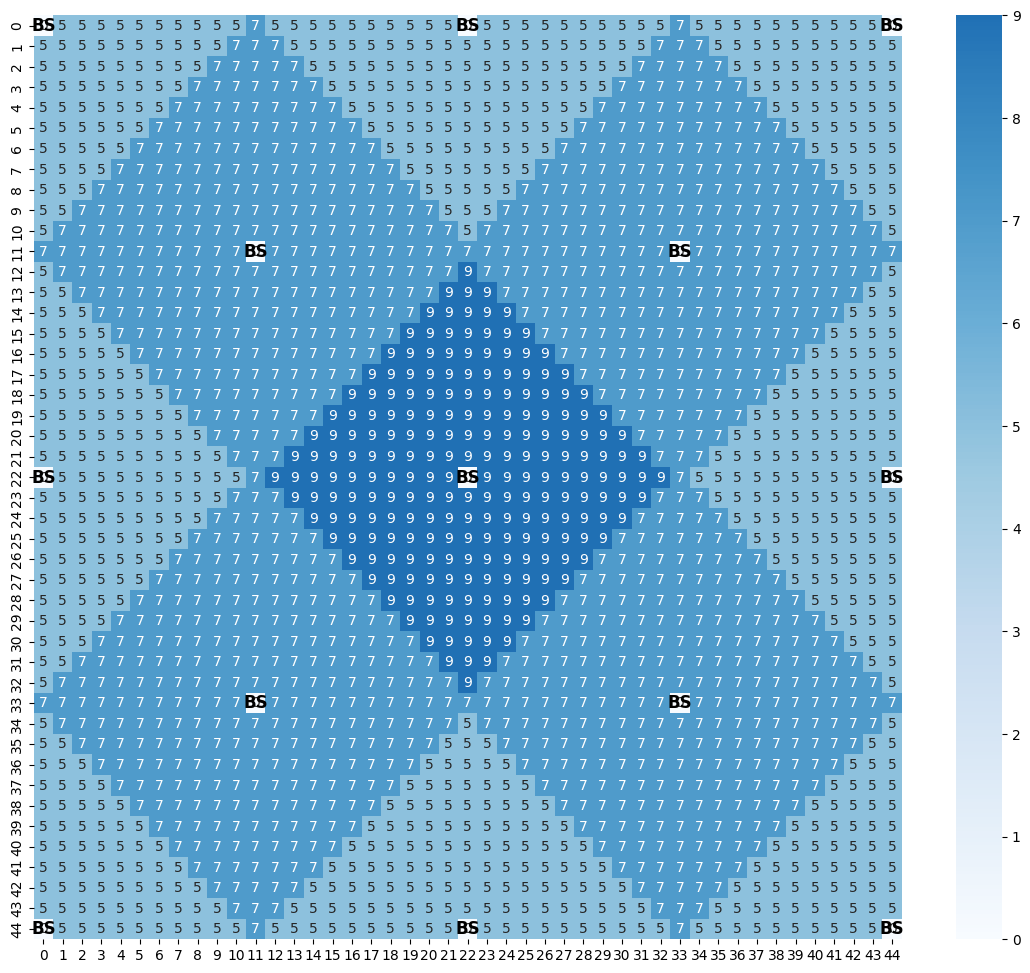

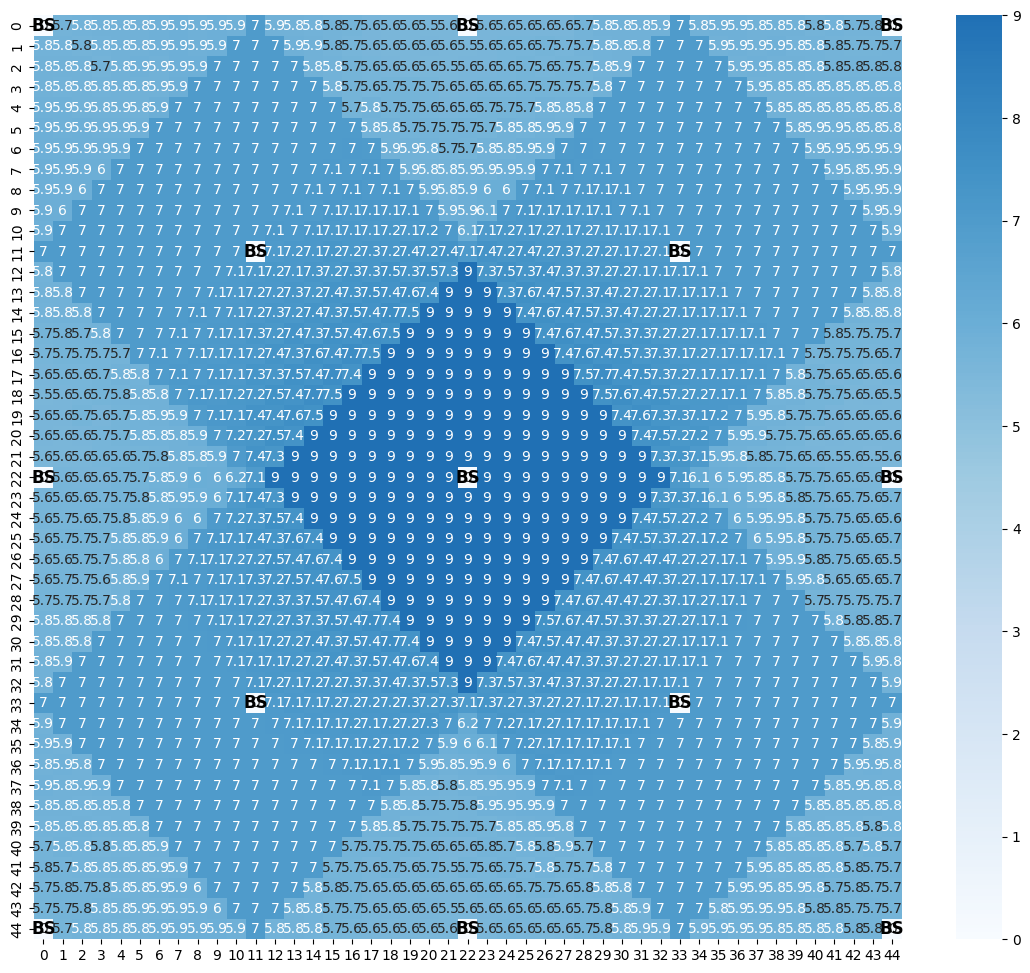

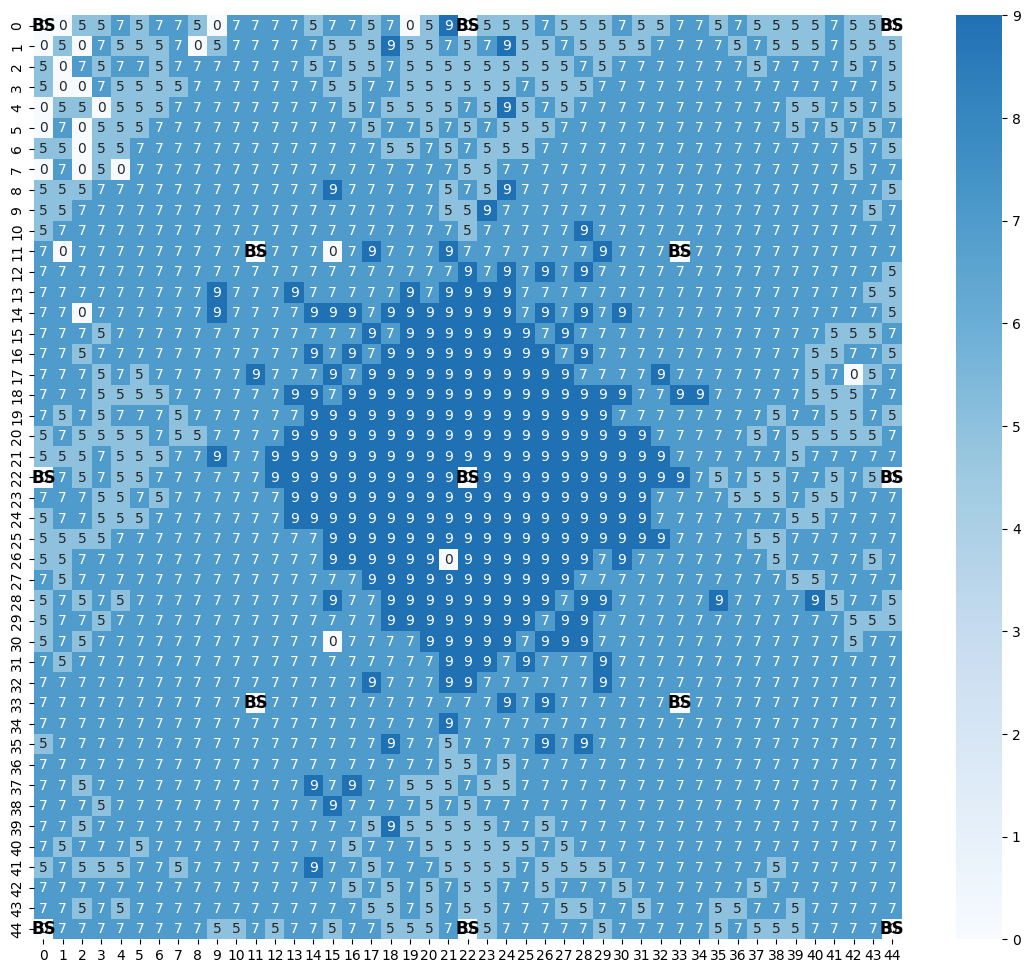


Lower Service Environment / SINR_Based / Hard Handoff Mobile: 
All Handoff Events:  1924272
Neglected(soft) handoffs:  0
Actual handoffs:  1924272
Neglect Percentage:  0.0
Average Allocation: 6.233843555555555
Min Allocation: 6.1108
Max Allocation: 6.331733333333333

Lower Service Environment / SINR_Based / Soft Handoff Mobile: 
All Handoff Events:  1926554
Neglected(soft) handoffs:  740702
Actual handoffs:  1156642
Neglect Percentage:  0.3845
Average Allocation: 6.585241777777779
Min Allocation: 6.479866666666667
Max Allocation: 6.6916


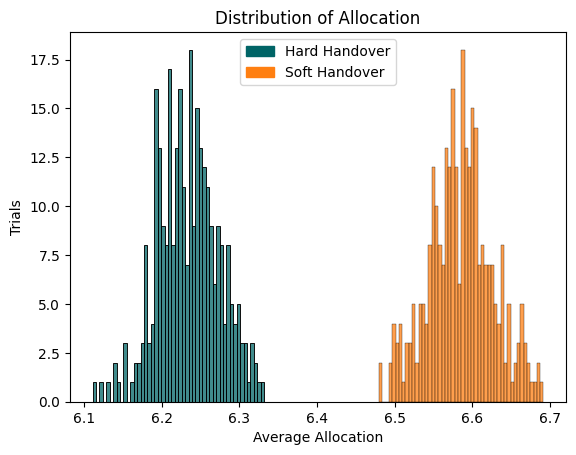

<Figure size 1400x1200 with 0 Axes>

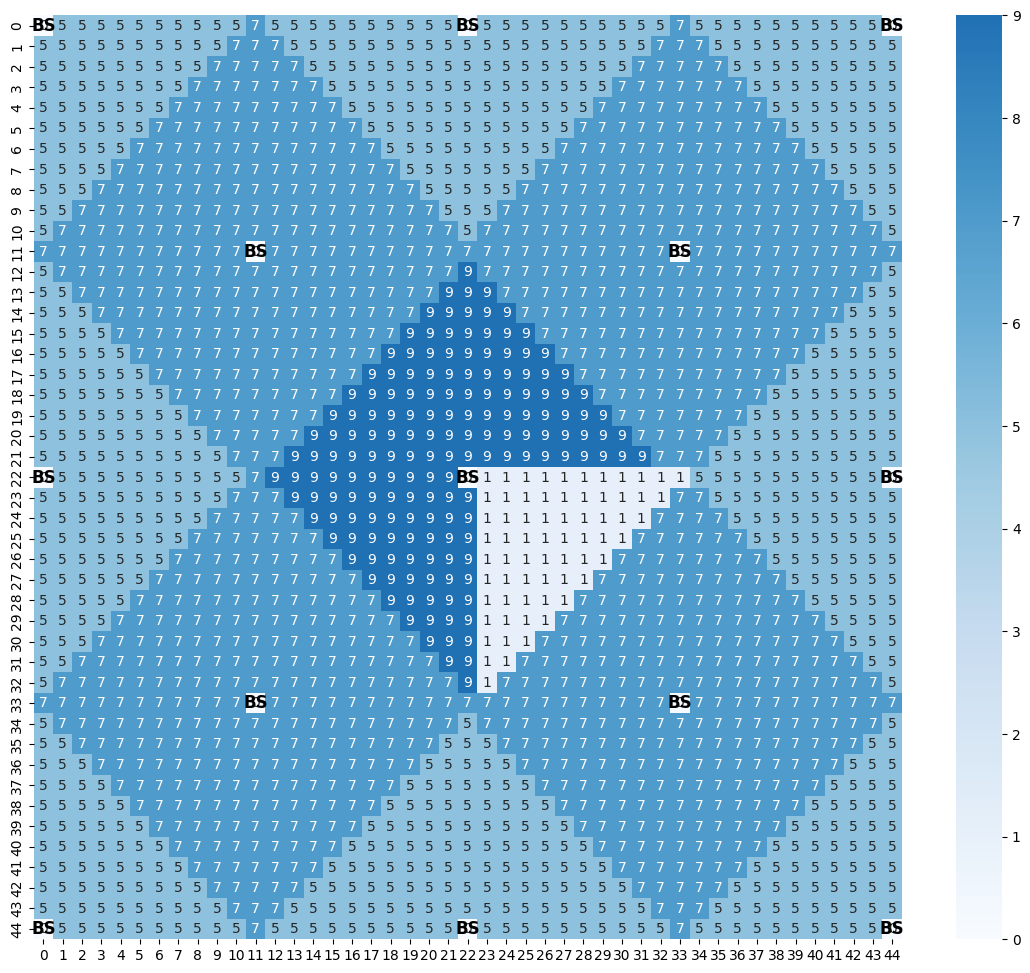

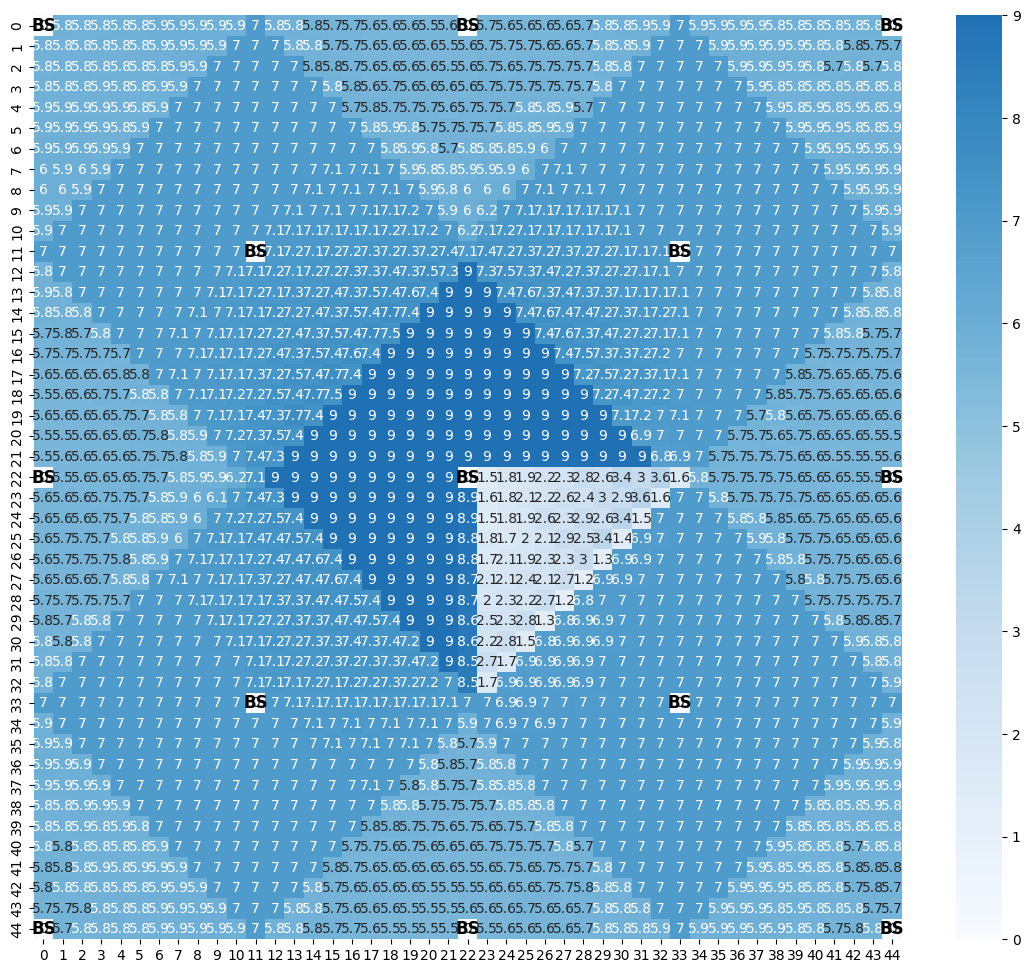

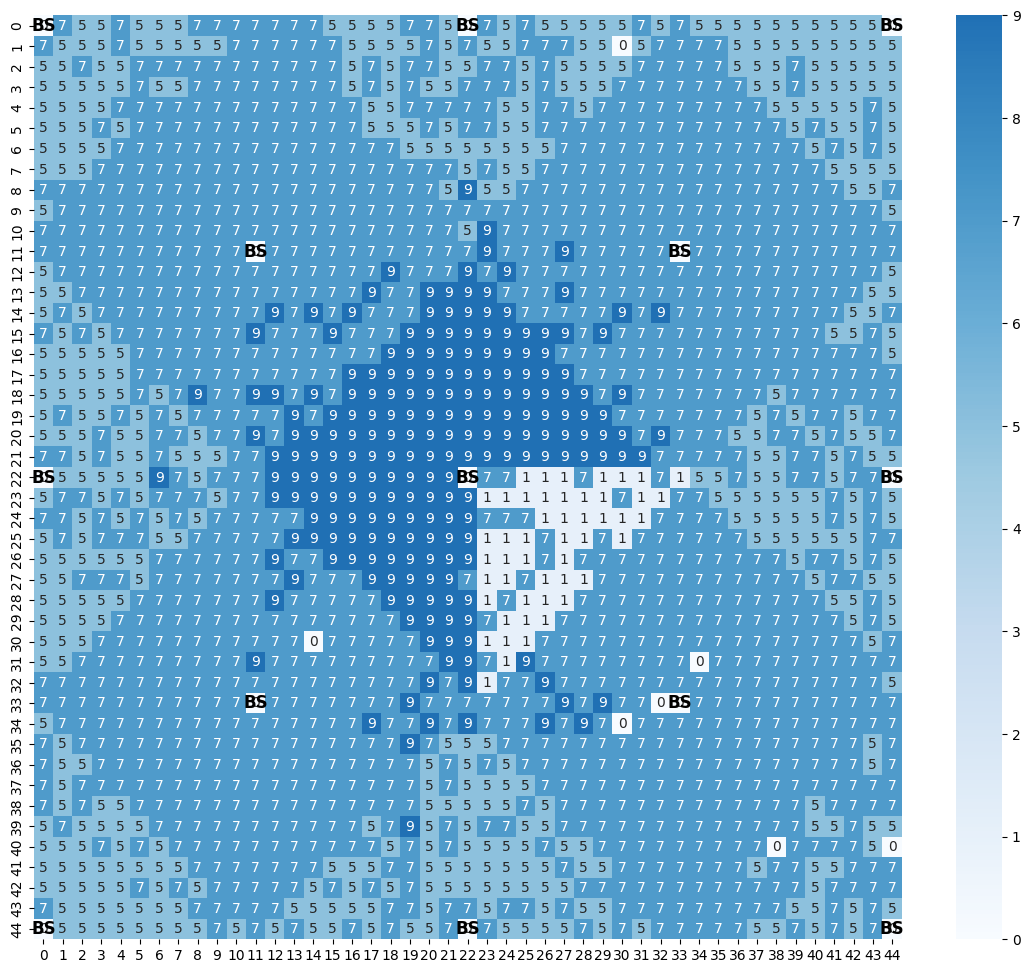

In [ ]:
# ----------------------------- Experiment 3 -----------------------------
test = 0

run3vals = []
run3means = []
run3stds = []
run3heatmaps = []
run3lastallocations = []

print("\nNormal Environment / SINR_Based / Hard Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=False,num_trials=300, num_walks=15000, num_steps=speed, exp_type="sinr", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=False,num_trials=10, num_walks=10, num_steps=speed, exp_type="sinr", debug=False)

run3vals.append(average_allocs)
run3means.append(np.mean(average_allocs))
run3stds.append(np.std(average_allocs))
run3heatmaps.append(heatmap)
run3lastallocations.append(lastallocation)

print("\nNormal Environment / SINR_Based / Soft Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=False,num_trials=300, num_walks=15000, num_steps=speed, exp_type="sinr", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=False,num_trials=10, num_walks=10, num_steps=speed, exp_type="sinr", debug=False)

run3vals.append(average_allocs)
run3means.append(np.mean(average_allocs))
run3stds.append(np.std(average_allocs))
run3heatmaps.append(heatmap)
run3lastallocations.append(lastallocation)

# Plots for Experiment 1

df = pd.DataFrame()
df["Scenario 1"] = run3vals[0]
df["Scenario 2"] = run3vals[1]


sns.histplot(run3vals[0], color = '#006466', bins=50, element="bars")
sns.histplot(run3vals[1], color = '#ff7f11', bins=50, element="bars")

teal_patch = mpatches.Patch(color='#006466', label='Hard Handover')
coral_patch = mpatches.Patch(color='#ff7f11', label='Soft Handover')

plt.legend(handles=[teal_patch, coral_patch])
plt.xlabel("Average Allocation")
plt.ylabel("Trials")
plt.title('Distribution of Allocation')
plt.figure(figsize=(14, 12))  # Set width and height
plt.savefig("SINR_histogram.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run3heatmaps[0],cmap="Blues", center = 6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_hardhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run3heatmaps[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_softhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run3lastallocations[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_softhandover_single.png", dpi=300)
plt.show()
plt.close()


# ----------------------------- Experiment 4 -----------------------------

run4vals = []
run4means = []
run4stds = []
run4heatmaps = []
run4lastallocations = []

print("\nLower Service Environment / SINR_Based / Hard Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=300, num_walks=15000, num_steps=speed, exp_type="sinr", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=10, num_walks=10, num_steps=speed, exp_type="sinr", debug=False)

run4vals.append(average_allocs)
run4means.append(np.mean(average_allocs))
run4stds.append(np.std(average_allocs))
run4heatmaps.append(heatmap)
run4lastallocations.append(lastallocation)


print("\nLower Service Environment / SINR_Based / Soft Handoff Mobile: ")

if not test: average_allocs, heatmap, lastallocation = main_function(soft_handoff=True, low_service_area=True, num_trials=300, num_walks=15000, num_steps=speed, exp_type="sinr", debug=False)
else: average_allocs, heatmap, lastallocation = main_function(soft_handoff=False, low_service_area=True,num_trials=10, num_walks=10, num_steps=speed, exp_type="sinr", debug=False)

run4vals.append(average_allocs)
run4means.append(np.mean(average_allocs))
run4stds.append(np.std(average_allocs))
run4heatmaps.append(heatmap)
run4lastallocations.append(lastallocation)


# Plots for Experiment 4

df = pd.DataFrame()
df["Scenario 1"] = run4vals[0]
df["Scenario 2"] = run4vals[1]


sns.histplot(run4vals[0], color = '#006466', bins=50, element="bars")
sns.histplot(run4vals[1], color = '#ff7f11', bins=50, element="bars")

teal_patch = mpatches.Patch(color='#006466', label='Hard Handover')
coral_patch = mpatches.Patch(color='#ff7f11', label='Soft Handover')

plt.legend(handles=[teal_patch, coral_patch])
plt.xlabel("Average Allocation")
plt.ylabel("Trials")
plt.title('Distribution of Allocation')
plt.figure(figsize=(14, 12))  # Set width and height
plt.savefig("SINR_deadzone_histogram.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run4heatmaps[0],cmap="Blues", center = 6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_deadzone_hardhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run4heatmaps[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_deadzone_softhandover_avg.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(14, 12))  # Set width and height
ax = sns.heatmap(run4lastallocations[1], cmap="Blues", center=6, annot=True)
for coord in BS_coords:
    ax.text(coord[1] + 0.5, coord[0] + 0.5, "BS", ha="center", va="center", fontsize=12, fontweight='bold', color='black')
plt.savefig("SINR_deadzone_softhandover_single.png", dpi=300)
plt.show()
plt.close()